In [1]:
# 基本模块导入
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 读取数据和查看

In [2]:
df = pd.read_csv('../Data/processed.cleveland.data', header=None)

In [3]:
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',\
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
df.columns = columns
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## 处理缺失值

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null float64
sex         303 non-null float64
cp          303 non-null float64
trestbps    303 non-null float64
chol        303 non-null float64
fbs         303 non-null float64
restecg     303 non-null float64
thalach     303 non-null float64
exang       303 non-null float64
oldpeak     303 non-null float64
slope       303 non-null float64
ca          303 non-null object
thal        303 non-null object
target      303 non-null int64
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


In [5]:
df[(df['ca']=='?') | (df['thal']=='?')] # 处理'ca'和‘thal’中的缺失值

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [6]:
df_no_missing = df.query("ca!='?' & thal!='?'") # 删除有缺失值的个案

In [7]:
df_no_missing['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0'], dtype=object)

In [8]:
df_no_missing['thal'].unique()

array(['6.0', '3.0', '7.0'], dtype=object)

## 分割数据并编码

In [9]:
X = df_no_missing.drop('target', axis=1).copy()
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [10]:
y = df_no_missing['target'].copy()
y.head()

0    0
1    2
2    1
3    0
4    0
Name: target, dtype: int64

In [11]:
# 变换 y 值为{0, 1}
y = y.apply(lambda x: 1 if x in [1,2,3,4] else x)
y.unique()

array([0, 1])

In [12]:
# 将'cp'列的值进行有序排列
X['cp'] = pd.Categorical(X['cp'], categories=[1,2,3,4], ordered=True)
X['cp']

0      1
1      4
2      4
3      3
4      2
      ..
297    4
298    1
299    4
300    4
301    2
Name: cp, Length: 297, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [13]:
# 对X进行0，1编码
encoder = ['restecg', 'slope', 'thal']
X_encoded = pd.get_dummies(X, columns=encoder) 
X_encoded.shape

(297, 19)

## 创建决策树模型

### 创建普通决策树并制图

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, plot_confusion_matrix

In [15]:
# 随机划分训练集，测试集
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

In [16]:
# 建模
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [17]:
# 查看精准率，召回率，f1分数，accuracy=0.72
pred = clf_dt.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        42
           1       0.65      0.79      0.71        33

    accuracy                           0.72        75
   macro avg       0.73      0.73      0.72        75
weighted avg       0.73      0.72      0.72        75



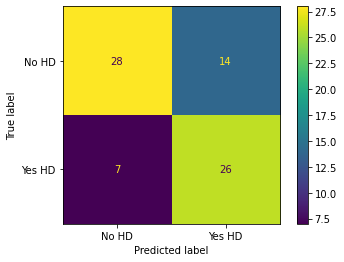

In [18]:
# 画出混淆矩阵
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=['No HD', 'Yes HD'])

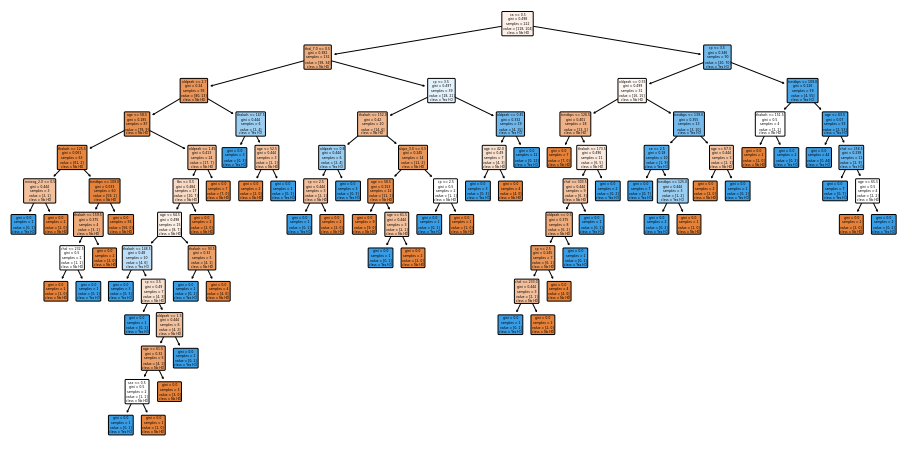

In [19]:
plt.figure(figsize=[16,8])
plot_tree(clf_dt,
         filled=True,
         rounded=True,
         class_names=['No HD', 'Yes HD'],
         feature_names=X_encoded.columns);

### 使用ccp_alpha优化决策树

In [20]:
clf_dt_ccp = DecisionTreeClassifier(random_state=42)

In [21]:
# 获取ccp_alphas
path = clf_dt_ccp.cost_complexity_pruning_path(X_encoded, y)
path['ccp_alphas']

array([0.        , 0.00205761, 0.00221729, 0.0030303 , 0.00306091,
       0.00325326, 0.00350564, 0.00399052, 0.00448934, 0.00448934,
       0.00448934, 0.00505051, 0.00505051, 0.00513067, 0.00513067,
       0.00526185, 0.00538721, 0.00541126, 0.00550924, 0.00613371,
       0.00635491, 0.00707071, 0.00721265, 0.00722855, 0.00785634,
       0.00897868, 0.01306546, 0.01335251, 0.01541293, 0.02952561,
       0.03284247, 0.03338958, 0.13697134])

In [22]:
# 获取最佳ccp_alpha
values = []
for ccp_alpha in path['ccp_alphas']:
    clf_ccp = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    score = cross_val_score(clf_ccp, X_encoded, y, cv=5)
    values.append([ccp_alpha, score.mean(), score.std()])
score_df = pd.DataFrame(values, columns=['ccp_alpha', 'score', 'score_std'])
score_df # 由下表可见ccp_alpha=0.015413时，score最高

,ccp_alpha,score,score_std
0,0.000000,0.716723,0.092368
1,0.002058,0.716723,0.092368
2,0.002217,0.716723,0.092368
3,0.003030,0.716723,0.092368
4,0.003061,0.716723,0.092368
5,0.003253,0.720113,0.093058
6,0.003506,0.720113,0.093058
7,0.003991,0.723503,0.094232
8,0.004489,0.730282,0.080577
9,0.004489,0.730282,0.080577


In [23]:
# 创建最佳决策树
ccp_alpha_best = score_df.loc[score_df['score'].idxmax() , 'ccp_alpha']
clf_dt_best = DecisionTreeClassifier(ccp_alpha=ccp_alpha_best, random_state=42)
clf_dt_best.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.015412926385396188, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=42, splitter='best')

In [24]:
# 通过优化，accuracy=0.83,比优化前提升0.11个百分点
pred1 = clf_dt_best.predict(X_test)
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        42
           1       0.78      0.85      0.81        33

    accuracy                           0.83        75
   macro avg       0.82      0.83      0.83        75
weighted avg       0.83      0.83      0.83        75



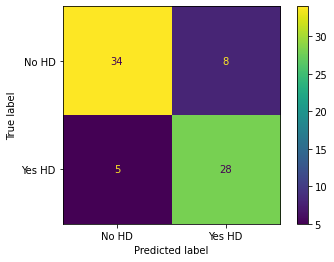

In [25]:
plot_confusion_matrix(clf_dt_best, X_test, y_test, display_labels=['No HD', 'Yes HD'])

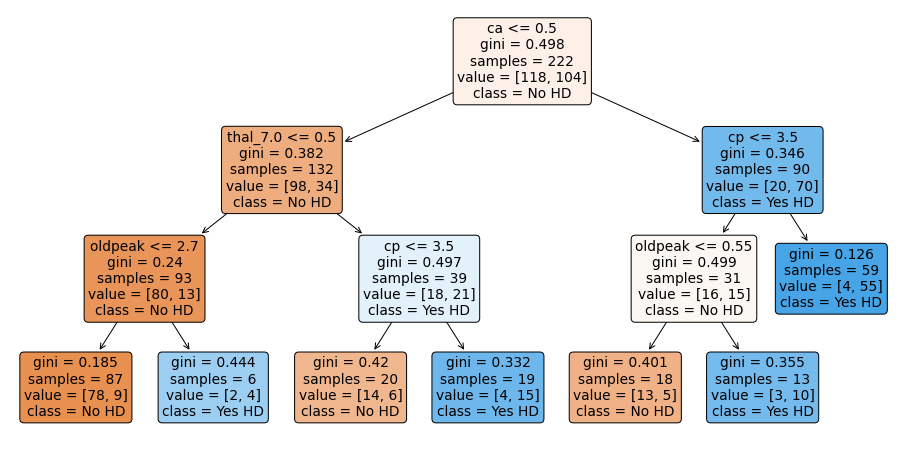

In [26]:
# 优化后的树更简洁
plt.figure(figsize=[16,8])
plot_tree(clf_dt_best,
          filled=True,
          rounded=True,
          class_names=['No HD', 'Yes HD'],
          feature_names=X_encoded.columns);